# Training Data

The training data is generated using real HSC images from the Ultra Deep (UD) field. The ground truth source detection masks are generated using the [scarlet](https://github.com/pmelchior/scarlet) deblender. HSC UD data can be accessed from https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/. We used the public DR2 UD stacks from: https://hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results. The HSC DR2 data is described in [Hiroaki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract).

In [1]:
import sys
# In case you need to point to pre-existing scarlet install
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [2]:
import sys, os
import numpy as np
import scarlet
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D
from astropy.io import ascii

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.1
1.1.1


In [4]:
def write_scarlet_results(datas, 
                          norm,
                          observation,
                          starlet_sources, 
                          model_frame, 
                          segmentation_masks, 
                          dirpath,
                          filters,
                          tract, 
                          patch, 
                          cutout_size):
    """
    Saves images in each channel, with headers for each source in image,
    s.t the number of headers=number of sources detected in image.
    
    Parameters
    ----------
    abc!
    
    
    
    Returns
    -------
    abc!
    """
    ##############################
    # SAVE RESULTS!!!
    
    for ch, f in enumerate(filters): # datas is HSC data array with dimensions [filters, N, N]
        f = f.upper()
        full_img_ch = scarlet.display.img_to_rgb(datas[ch], norm=norm)
    
        save_hdu = fits.PrimaryHDU(data=full_img_ch) # Primary HDU is full image
        #header = save_hdu.header # each full image has a header with height, width of image
        #header['h'] = full_img_ch.shape[0]
        #header['w'] = full_img_ch.shape[1]
        #header['area'] = header['w'] * header['h']

        # Save each model source in the image
        save_starlet_source_list = []

        if segmentation_masks is not None:
            for k, src in enumerate(starlet_sources):

                # Get each model, make into image
                model = starlet_sources[k].get_model(frame=model_frame)
                model = observation.render(model)
                model = src.bbox.extract_from(model)

                # Source image
                src_img = scarlet.display.img_to_rgb(model, norm=norm)

                # Save model with location info (relative to full image file) in headers
                save_hdu_ss = fits.ImageHDU(data=src_img) #Ensure it's IMAGE HDU NOT PRIMARY
                
                # Save 1 header per 1 source detected
                save_hdr_ss = fits.Header()
                
                # For each header, assign descriptive data about each source
                src_y = starlet_sources[k].center[0] # y-coord of the source's center
                src_x = starlet_sources[k].center[1] # x-coord of the source's center
                src_h = src_img.shape[0]
                src_w = src_img.shape[1]
                
                save_hdr_ss['area'] = src_w * src_h
                save_hdr_ss['bbox'] = str([src_x, src_y, src_w, src_h])
                save_hdr_ss['seg_mask'] = str(ascii.write(segmentation_masks[k])) # 0 or 1 image data
                save_hdr_ss['cat_id'] = 1 # Category ID #TODO: set categor_id based on if the source is extended or not
                
                save_starlet_source_list.append(save_hdu_ss)

            # Write final fits file to specified location   
            # Save full image and then headers per source w/ descriptive info
            save_hdul = fits.HDUList([save_hdu, save_starlet_source_list[0]])
            save_hdul.writeto(f'{dirpath}HSC-{f}/{tract}/{patch[0]},{patch[1]}/calexp-HSC-{f}-{tract}-{patch[0]},{patch[1]}_scarlet.fits') 
    
        

        

### Test Scarlet

First, let's test scarlet using one HSC UD image. The HSC image data is divided into "tracts" and "patches" on the sky. You can get the HSC image data given any ra, dec using the code below.

View HSC tract maps: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/

Tract, patch from coord: 9814 (6, 6)
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9814/6,6/calexp-HSC-G-9814-6,6.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9814/6,6/calexp-HSC-R-9814-6,6.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9814/6,6/calexp-HSC-I-9814-6,6.fits".


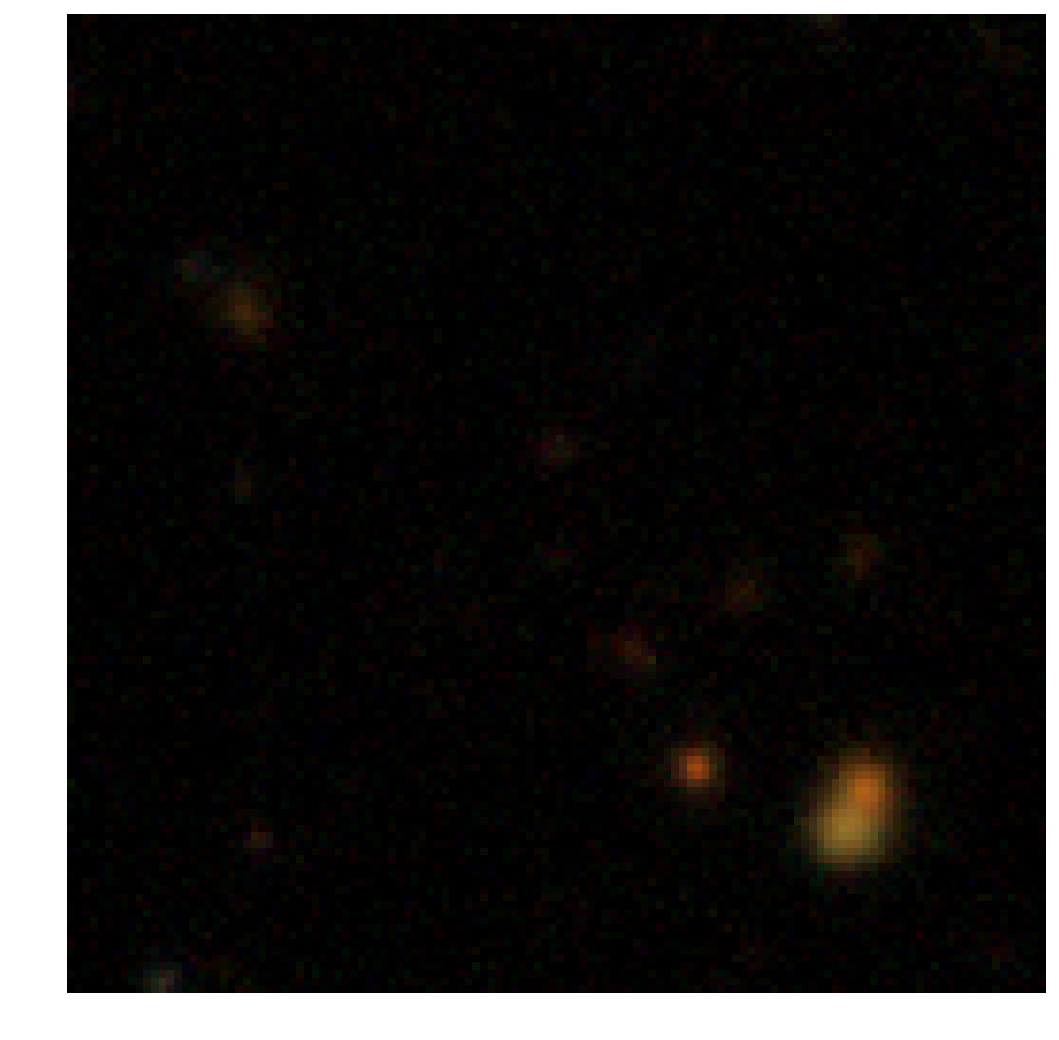

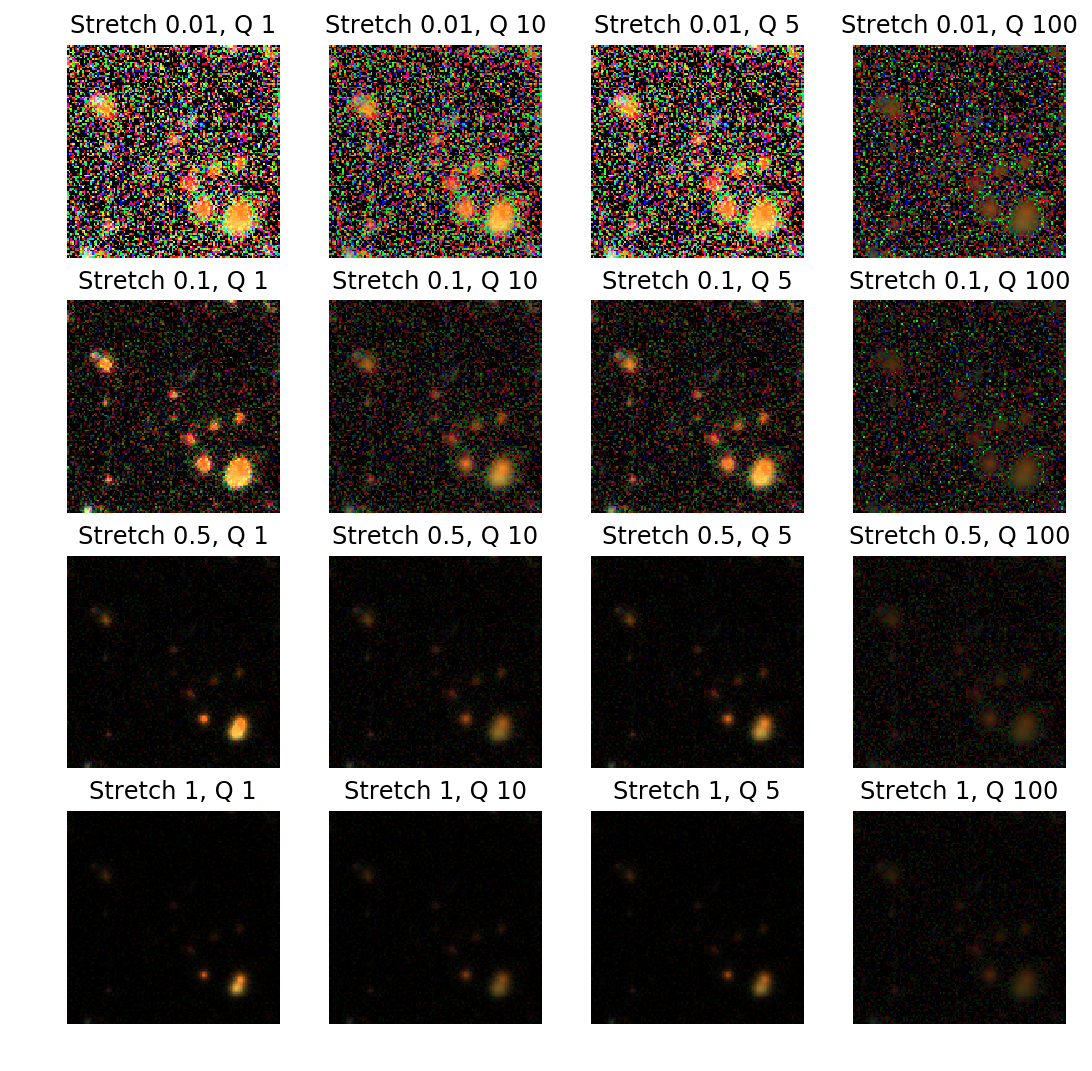

In [5]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data
from astrodet.scarlet import plot_stretch_Q, run_scarlet

filters = ['g', 'r', 'i']

# Input coordinate
c = SkyCoord(151.3818, 2.5851, unit='deg')

# Get the tract, patch
tract, patch = get_tract_patch_from_coord(c)
print('Tract, patch from coord:', tract, patch)

# Point to the HSC data directory
hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/'

# Get the HSC data from the file info
# Alternatively, you can add the coord argument directly into the arguments below
cutout_size = [128,128]
datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, tract=tract, patch=patch, cutout_size=cutout_size)

# Plot image data
fig, ax = plt.subplots(1, 1, figsize=(9,9))
norm = scarlet.display.AsinhMapping(minimum=0, stretch=1, Q=5)
img_rgb = scarlet.display.img_to_rgb(datas, norm=norm)
ax.imshow(img_rgb)
ax.axis('off')

# Find good stretch and Q
fig = plot_stretch_Q(datas);

Run scarlet on image

sigma_obs: 2.0 pixels.
Source catalog found  11 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 5 iterations to logL = -45219.166792840406


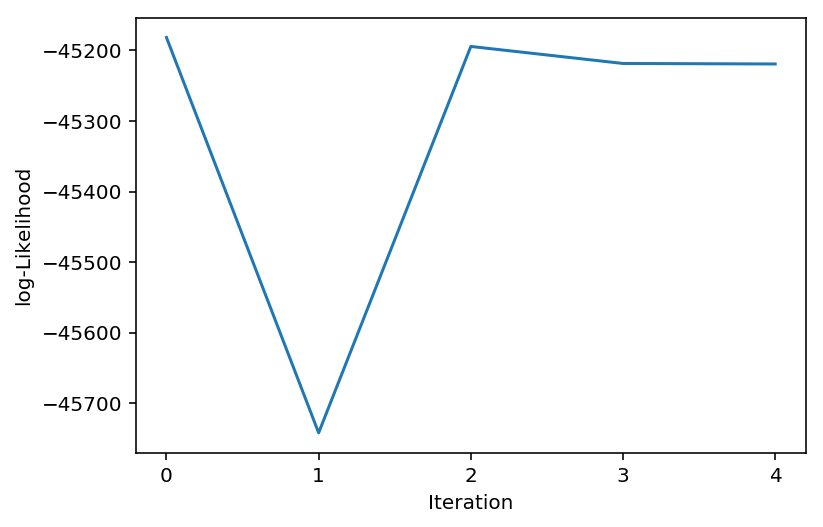

Computing residuals.
Extracting deblended catalog.


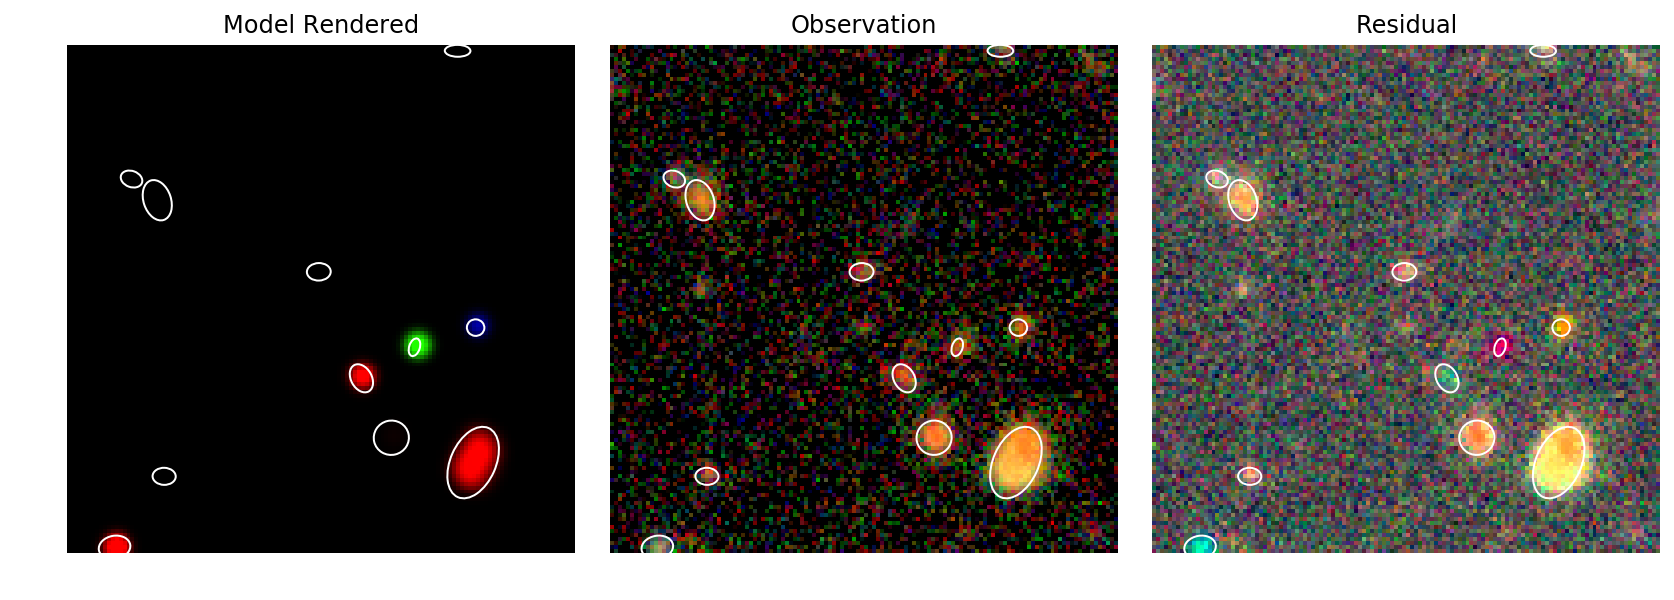

col0 col1 col2 col3 col4 col5 col6 col7 col8 col9 col10 col11 col12 col13 col14 col15 col16 col17 col18 col19 col20 col21 col22 col23 col24 col25 col26 col27 col28 col29 col30 col31 col32 col33 col34 col35 col36 col37 col38 col39 col40
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
# HSC pixel scale in arcsec/pixel
ps = 0.17
# Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
print(f'sigma_obs: {np.around(sigma_obs, 2)} pixels.')

# Run Scarlet
# START TIMING with plotting OFF
out = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True, max_chi2=5000)
# END TIMING

observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out


# Save Scarlet data to FITS file
write_scarlet_results(datas, 
                      norm,
                      observation,
                      starlet_sources, 
                      model_frame, 
                      segmentation_masks, 
                      dirpath=hsc_dirpath, 
                      filters=filters, 
                      tract=tract, 
                      patch=patch, 
                      cutout_size=cutout_size)

In [7]:
def generate_training_data(dirpath, bands=['g','r','i'], ratios=[1, 0.2, 0.2]):
    
    """
    Description.
    
    
    
    """
    
    import glob
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    b = bands[0]
    
    # /home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/**/**/**/calexp-HSC-G*.fits.gz
    files = glob.glob(os.path.join(dirpath, f'HSC-{b.upper()}/**/**/calexp-HSC-{b.upper()}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # TODO: This looses a couple files
    files_train = files[:i_train]
    files_val = files[i_train:i_train + i_val]
    files_test = files[-i_test:]
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Get tract, patch (use first band)
        for fi in f:
            
            # TODO: Do some multiprocessing

            s = fi.split(f'calexp-HSC-{b.upper()}-')[1].split('.fits.gz')[0]
            tract, patch = s.split('-')
            patch = tuple(map(int, patch.split(',')))
            
            # Get the HSC data from the file info
            #datas = get_hsc_data(dirpath=hsc_dirpath, bands=bands, tract=tract, patch=patch)
            
            # TODO: Split data up into chunks if you need to

            # Run Scarlet
            #observation, scarlet_sources = run_scarlet(datas, plot_scene=True)

            # Save Scarlet data to FITS file
            #write_scarlet_results(observation, scarlet_sources)
        
    return files_train, files_val, files_test

In [156]:
generate_training_data(hsc_dirpath)